## LINE LENGTH PREDICTOR V1 - Linear Regression

In [1]:
import os
from scipy import misc
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import SGDRegressor

import math
import scipy as sc
import pickle

%matplotlib inline



## Our data set

In [2]:
folder = 'IMAGES_1000_ALL_ANGLES_LENGTHS'
noOfImages = 1000
dim =100 

## Utilities for feature extraction

In [3]:
def RotateImage(image, dim):
    
    new_image = np.zeros((dim, dim), dtype=np.uint8)
    new_image[:,:] = 255 
     
    # Rotate
    for row in range(0,100): # Visit all collumns
        for col in range(0,100): 
            new_image[ dim - row -1,col] = image[row,  col] 

    # Copy back 
    for row in range(0,100): # Visit all collumns
        for col in range(0,100): 
             image[row,  col] = new_image[row, col]

In [4]:
'''
For finding the distance between points
'''
def Distance(x1,y1,x2,y2):
    dx = x1-x2
    dy = y1-y2
    
    d= math.sqrt(  (dx*dx) + (dy*dy) )
    return d
    
d= Distance(0,99,63 ,36)
print(d)

d= Distance(0,99,98 ,1)
print(d)

89.09545442950498
138.59292911256333


In [5]:
'''
For projecting the image on the y axis
'''
def Get_Y_Shadow(image):
    dim = 100  
    #y_shadow =  np.zeros(dim, dtype=np.uint8) 
    y_shadow =  np.full(dim,  255) 
    index= 0
    
    # Start from left col (x=0) to last col (x= 99
    for col in range(0,100): # Visit all collumns
        for row in range(0,100): 
            gray = image[row,  col]
            if  gray == 0 : # Look for non-white pixels
                # Project on y-axis
                if y_shadow[row]== 255: # Move if not was already plotted
                    index = index + 1  
                # Project on y-axis
                y_shadow[row]= col # y_shadow[row] + 1 
                 
     
    #print(index)
    # ADJUSTED index needs to be less one
    index = index -1
    
    return y_shadow,index
                    

In [6]:
'''
For projecting the image on the x axis
'''
def Get_X_Shadow(image):
    dim = 100  
    #x_shadow =  np.zeros(dim, dtype=np.uint8) 
    x_shadow =  np.full(dim,  255) 
        
    index= 0
    
    # Start from top row (y=99) to last row (y= 99
    for row in range(0,100): # Visit all collumns
        for col in range(0,100): 
            gray = image[row,  col]
            if  gray == 0 : # Look for non-white pixels
                
                if x_shadow[col]== 255: # Move if not was already plotted
                    index = index + 1  
                # Project on y-axis
                x_shadow[col]= dim - 1- row #x_shadow[col] + 1 
     
    #print(index)
    
    # ADJUSTED index needs to be less one
    index = index -1
    
    return x_shadow,index
                    

In [7]:
def getFirstFromLeft(a, dim):
    for i in range(0,dim):
        if   a[i] != 255 :
            #print('From left: {}:{}'.format( i,a[i] ))
            return a[i]  

In [8]:
def getFirstFromRight(a, dim):
    for i in range(dim-1,-1,-1):
        #print(i)
        if   a[i] != 255 :
            #print('From right: {}:{}'.format( i,a[i] ))
            return a[i]  

In [9]:
def Count(image, gray, dim): 
    c = 0
    for row in range(0,100): 
        for col in range(0,100):  
            if image[row,  col] == gray :  
                c= c+ 1 
    return c
                    

In [10]:
'''
For reducing the features, we condense the columns into one column
and the rows in one row. We will reduce and work with two features
    - yShadow
    - xShadow
'''
def ExtractImageFeatures( image, dim):
    
    # Safety check - do now work with empty images!
    # if data may have empty images enables this
    # c= Count(image, 0, 100)
    # if c== 0:
    #    print ("***EMPTY IMAGE FOUND!!!!") 
    #    return 0,0
     
 
    yShadow,dy = Get_Y_Shadow(image) 
    xShadow,dx = Get_X_Shadow(image)
 
    # Do not use negative for Line Length's
    #lineDescends = CheckIfDescends(xShadow,dim)
    #if lineDescends:
    #    dy = -1*dy
        
    return dx,dy
    

## Create an array to store yShadow and xShadow

In [11]:
print(dim)
print(noOfImages)
print(folder)

x_data = np.zeros((noOfImages, 2))

#x_data = np.zeros((noOfImages, dim*2))
print( x_data.shape)

100
1000
IMAGES_1000_ALL_ANGLES_LENGTHS
(1000, 2)


## Read x_data, all images in an array

In [12]:
'''
For loop that reads and processes all the images into a X
'''  

for count in range(0,noOfImages ):
           
    filename = "./DATA/" + str(folder) + "/"+ "im_" +str(count) + ".bmp" 
    
    image= misc.imread(filename, flatten= 1)   
     
    # Later need to try to use the shadows themself directly!
    dx,dy = ExtractImageFeatures( image, dim)
    
    # Using dx and dy extracted from image
    x_data[count,0]= dx
    x_data[count,1]= dy
   
    

C:\Users\admin\Anaconda3\envs\mldds\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':


In [13]:
x_data.shape

(1000, 2)

## Read y_data

In [14]:

filename = "./DATA/" + str(folder) + "/"+ "ydata.csv"  
   
#yDataFrame.to_csv(filename, index =False)
#yDataFrame.to_csv?

# Read data frame
yDF= pd.read_csv(filename)
yDF.head(10)

yAngle = pd.DataFrame( yDF.loc[:,'angle'])

#yAngle.head(10)

yLength =  pd.DataFrame( yDF.loc[:,'length'])
 
x1_DF =  pd.DataFrame( yDF.loc[:,'x1'])
y1_DF =  pd.DataFrame( yDF.loc[:,'y1'])
x2_DF =  pd.DataFrame( yDF.loc[:,'x2'])
y2_DF =  pd.DataFrame( yDF.loc[:,'y2'])

print("Mean=>{}".format( yAngle.mean() ))
print("Mean=>{}".format( yLength.mean()))

print("Mean=>{}".format( x1_DF.mean() ))
print("Mean=>{}".format( y1_DF.mean()))

print("Mean=>{}".format( x2_DF.mean() ))
print("Mean=>{}".format( y2_DF.mean()))

#print(yDF)


Mean=>angle    1.213372
dtype: float64
Mean=>length    47.330844
dtype: float64
Mean=>x1    50.059
dtype: float64
Mean=>y1    49.18
dtype: float64
Mean=>x2    50.091
dtype: float64
Mean=>y2    50.963
dtype: float64


In [15]:
#Our Target
yLength.head(10)

,length
0,44.80
1,46.88
2,41.00
3,18.44
4,64.00
5,46.06
6,47.72
7,110.30
8,81.00
9,68.25


In [16]:
X= x_data
y= yLength
print (x_data.shape)
print(y.shape)

(1000, 2)
(1000, 1)


In [17]:
x_data_DF = pd.DataFrame(x_data)
x_data_DF.head(10)

,0,1
0,34.0,27.0
1,45.0,9.0
2,0.0,40.0
3,4.0,17.0
4,1.0,63.0
5,20.0,40.0
6,25.0,39.0
7,76.0,78.0
8,75.0,28.0
9,55.0,38.0


In [18]:
yLength.head(10)

,length
0,44.80
1,46.88
2,41.00
3,18.44
4,64.00
5,46.06
6,47.72
7,110.30
8,81.00
9,68.25


## PCA with one component - Length

In [19]:
pca = PCA(n_components=1)

Z = pca.fit_transform(X) # Z is 2-D
print(Z.shape)
print(y.shape)

(1000, 1)
(1000, 1)


[Text(0, 0.5, 'Length'),
 Text(0.5, 0, 'f1'),
 Text(0.5, 1.0, 'PCA of data vs length')]

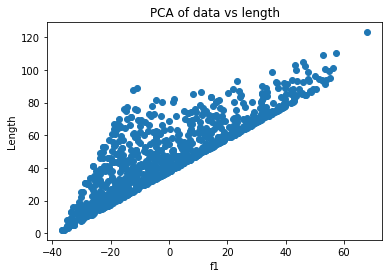

In [20]:
fig, ax = plt.subplots()
ax.scatter(Z,y)

ax.set( title = 'PCA of data vs length',
     xlabel = 'f1',
      ylabel= 'Length')

#***************************************************
# DO NOT REMOVE
# This is the plot of 100 images

## TRAINING

In [21]:
X= x_data
y= yLength

In [22]:
print(X.shape)
print(y.shape)

(1000, 2)
(1000, 1)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print( type(X_train),type(X_test),type(y_train),type(y_test))

(750, 2) (250, 2) (750, 1) (250, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [24]:
# Must be flatten is done
print( y_train.shape )
print(y_test.shape )


print( type (y_train ))

#y_train.ravel()

# Get argmin and argmax
a = np.array( [2,3])
a = np.array( [ [0,1,2], [3,4,5]])

print (type (y_train.values ))
y_train_values = y_train.values
print(y_train_values.shape)
y_train_values = y_train_values.ravel()
print(y_train_values.shape)

(750, 1)
(250, 1)
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
(750, 1)
(750,)


In [25]:
# Flatten or Ravel the  y_train.shape, y_test.shape
y_train = y_train.values.ravel()
print(y_train.shape)
y_test = y_test.values.ravel()
print(y_test.shape)

(750,)
(250,)


In [26]:
# scale X_train to normalise the feature ranges
X_scaler = StandardScaler()
Z_train = X_scaler.fit_transform(X_train)

In [27]:
# Linear Regression using Gradient Descent

sgd_model = SGDRegressor(max_iter=1000, 
                     tol=1e-3,
                     random_state=8)

 
scores = cross_validate(sgd_model, Z_train, y_train, cv=5,
                        return_train_score=True,
                        return_estimator=True) # models
scores

{'fit_time': array([0.01562333, 0.        , 0.        , 0.        , 0.        ]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'estimator': (SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
         eta0=0.01, fit_intercept=True, l1_ratio=0.15,
         learning_rate='invscaling', loss='squared_loss', max_iter=1000,
         n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
         random_state=8, shuffle=True, tol=0.001, validation_fraction=0.1,
         verbose=0, warm_start=False),
  SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
         eta0=0.01, fit_intercept=True, l1_ratio=0.15,
         learning_rate='invscaling', loss='squared_loss', max_iter=1000,
         n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
         random_state=8, shuffle=True, tol=0.001, validation_fraction=0.1,
         verbose=0, warm_start=False),
  SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,


In [28]:
# Get the best model
#print(scores.keys)
#print(scores[test_score])

#np.armax()
#print(type(scores))
#print(scores.keys())
#print(scores['test_score'])
test_score_array = scores['test_score']
iMax = test_score_array.argmax()
print('Index of max argument is {}'.format(iMax))
print('Maximum Test Score is {}'.format(test_score_array[iMax]))

Index of max argument is 3
Maximum Test Score is 0.9686116351036481


In [29]:
# Get the W and bias for each fitted linear regressor
for m in scores['estimator']:
    print('W', m.coef_, 'bias', m.intercept_)

W [15.52396391 15.53201023] bias [48.25187045]
W [15.84231175 15.39100659] bias [48.21619775]
W [15.46674717 15.65574372] bias [48.14588253]
W [15.45694096 15.65770919] bias [48.40485793]
W [15.51987258 15.62026173] bias [48.22842156]


In [30]:
# Score for test set (the 25% from train_test_split)
# Note that 'test_score' returned by cross_validate is actually
# 'validation score'. (easy to confuse)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

models = scores['estimator']

# Choose the best model
line_length_predictor = models[iMax]

# let's see the first model
Z_test = X_scaler.transform(X_test) # common mistake is to use
                                    # X_scaler.fit_transform
                                    # which will reset the scaler
y_pred = line_length_predictor.predict(Z_test)

print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred)) # scale-invariant

# FOR 1000 IMAGES
#MSE: 19.829834548041244
#MAE: 3.5753727011966205
#R2: 0.959758503948375

# FOR 2000 IMAGES
#MSE: 20.97814163309747
#MAE: 3.6671241292461043
#R2: 0.9619407896728098

MSE: 19.98019253869187
MAE: 3.629338985946194
R2: 0.9594533763149377


In [31]:
print(y_test.shape)
print(y_pred.shape)

df_y_pred = pd.DataFrame(y_pred)
df_y_test =  pd.DataFrame(y_test) 
#y_test.head(10)
print( df_y_test.head(10))
print( df_y_pred.head(10))

(250,)
(250,)
       0
0  22.20
1  23.77
2  48.28
3  59.22
4  41.30
5  23.27
6  46.50
7  52.80
8  69.44
9  33.12
           0
0  25.817776
1  26.550949
2  46.116567
3  50.560447
4  37.400374
5  26.529504
6  46.904329
7  57.055674
8  60.009812
9  30.142729


## Learning Curve

[Text(0, 0.5, 'R2'),
 Text(0.5, 0, 'Train size'),
 Text(0.5, 1.0, 'Learning curve')]

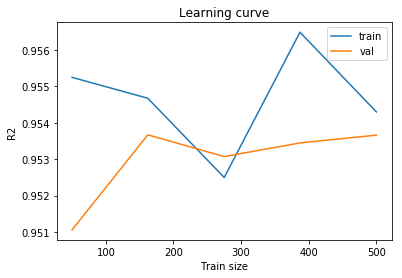

In [34]:
from sklearn.model_selection import learning_curve

# 5-fold cross validation to get learning curve R2 scores
# using default train_sizes
train_sizes, train_scores, val_scores = learning_curve(line_length_predictor,
                                                       Z_train, 
                                                       y_train, cv=3)

# plot learning curve:
#   plot train_scores vs. train_sizes
#   plot val_scores vs. train_sizes
# train_sizes is the number of training samples used for training

fig, ax = plt.subplots()
ax.plot(train_sizes, train_scores.mean(axis=1),
        label='train') # average for 5-folds
ax.plot(train_sizes, val_scores.mean(axis=1),
        label='val')
ax.legend()
ax.set(title='Learning curve', xlabel='Train size', ylabel='R2')


## Saving the model

In [35]:
# save model and scaler for later use
pickle.dump(X_scaler, open('length_predictor_X_scaler.pickle', 'wb'))
pickle.dump(line_length_predictor, open('length_predictor.pickle', 'wb'))




## Prediction on a given image

In [36]:
import math
import scipy as sc

def LoadScalerModel():
    X_scaler = pickle.load(open('length_predictor_X_scaler.pickle', 'rb'))
    model = pickle.load(open('length_predictor.pickle', 'rb'))
    
    return X_scaler, model



###  For user

In [37]:
def PredictLineLength():
    # We work with one image ( we extract two features)
    noOfImages =1
    dim = 100
    df_X = np.zeros((noOfImages, 2))

    # Load X_scaler and Model
    X_scaler, model = LoadScalerModel()
    
    # Extract image features


    dx,dy = ExtractImageFeatures( image, dim)
 

    # Store the extracted features 
    df_X[0,0]= dx
    df_X[0,1]= dy
 
    # let's see the first model
    df_Z = X_scaler.transform(df_X)  
                                    
    print("dx= {}, dy= {}".format(dx,dy))  
    
    y_pred = model.predict(df_Z )
    
    length_predict = y_pred[0]
    # print('Length predicted= {}'.format(angle_predict))
    
    return length_predict

    

## MAIN PREDICT

### Input your image

C:\Users\admin\Anaconda3\envs\mldds\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


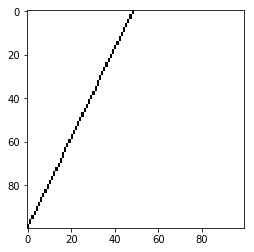

In [38]:
# Load image and display
image= sc.misc.imread("./TEST/test5.bmp", flatten= 1)
plt.imshow(image, cmap='gray') 

### Run the prediction

In [39]:
# Model is precise for ascending slopes, 
# but not for descending slopes

l= PredictLineLength()
 
    
print('Length predicted= {}'.format(l))

dx= 48, dy= 99
Length predicted= 111.57184633784183


### Check the prediction with dx and dy

In [40]:
print("Length should have been {}".format(Distance(0,0,48,99)))

Length should have been 110.02272492535349
